In [5]:
import pandas as pd
import pickle

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.metrics import mean_squared_error


In [8]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc_taxi_experiment")

<Experiment: artifact_location='/workspaces/mlops/01-intro/mlruns/1', creation_time=1755256866442, experiment_id='1', last_update_time=1755256866442, lifecycle_stage='active', name='nyc_taxi_experiment', tags={}>

In [9]:
def read_dataFrame(filename):
    data = pd.read_parquet(filename)
    #df = data.lpep_dropoff_datetime - data.lpep_dropoff_datetime
    
    data["duration"] = data.lpep_dropoff_datetime - data.lpep_pickup_datetime
    data.duration = data.duration.apply(lambda td: td.total_seconds()/60)
    
    data = data[(data.duration >= 1) & (data.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    data[categorical] = data[categorical].astype(str)
    
    return data


In [10]:
df_train = read_dataFrame("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")
df_val = read_dataFrame("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet")


In [11]:
len(df_train), len(df_val)

(54373, 51497)

In [12]:
#data = data[data.trip_type == 2]

In [17]:
((df_train.duration >= 1) & (df_train.duration <= 60)).mean()

1.0

In [20]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [21]:
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)


In [22]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [23]:

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.982610254412603

In [26]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)
    

In [33]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "Jayanth")
    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")
    mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet")
    
    alpha = 0.0001
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    mlflow.log_metric("rmse", rmse)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

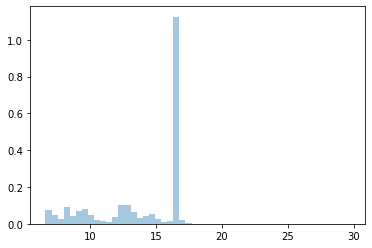

In [30]:
sns.distplot(y_pred, label='Prediction')
sns.distplot(y_train, label='Actual')

plt.legend()

In [ ]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [ ]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)